In [1]:
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install textblob
!pip install vaderSentiment
!pip install scikit-learn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import nltk
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = 'latin-1', header  = None)
df.columns = ["Targets", "Ids", "Date", "Flag", "User", "Tweet"]
df[['Targets', 'Tweet']].head()

,Targets,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### **Target = 0 -> negative tweet**
### **Target = 4 -> positive tweet**

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def preprocess(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    cleaned_words = []
    for word in words:
        if word.startswith("@") or word not in stop_words:
            cleaned_words.append(word)
    return " ".join(cleaned_words)
df["cleaned"] = df["Tweet"].apply(preprocess)
print(df["cleaned"].head())
    


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jinzo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    switchfoot httptwitpiccomyzl thats bummer shou...
1    upset cant update facebook texting might cry r...
2    kenichan dived many times ball managed save re...
3                     whole body feels itchy like fire
4             nationwideclass behaving im mad cant see
Name: cleaned, dtype: object


In [4]:
df["sentiment"] = df["Targets"].apply(lambda x: "positive" if x == 4 else "negative")

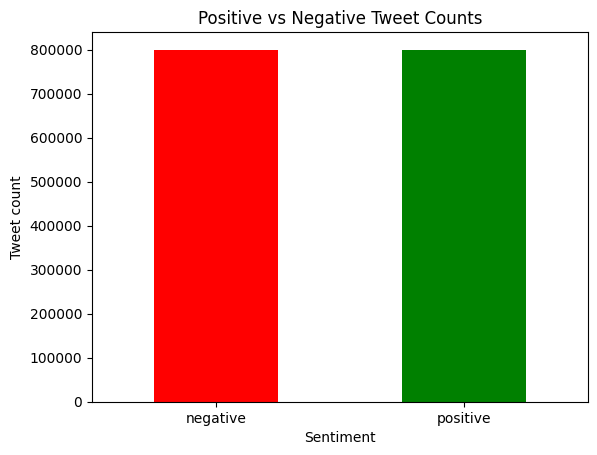

In [5]:
df["sentiment"].value_counts().plot(kind = 'bar', color = ["red", "green"])
plt.title("Positive vs Negative Tweet Counts")
plt.xlabel("Sentiment")
plt.ylabel("Tweet count")
plt.xticks(rotation = 0)
plt.show()

In [6]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity
df["polarity"] = df["cleaned"].apply(get_sentiment)

In [7]:
def label_sentiment(score):
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"
df["textblob_sentiment"] = df["polarity"].apply(label_sentiment)

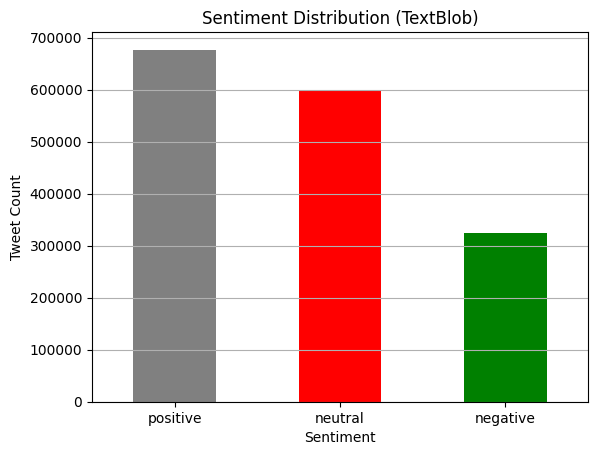

In [8]:
df["textblob_sentiment"].value_counts().plot(kind='bar', color=["gray", "red", "green"])
plt.title("Sentiment Distribution (TextBlob)")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [9]:
analyzer = SentimentIntensityAnalyzer()
def vader_sentiment(text):
 score = analyzer.polarity_scores(text)
 compound = score["compound"]
 if compound >= 0.05:
     return "positive"
 elif compound <= -0.05:
     return "negative"
 else:
     return "neutral"
df["vader_sentiment"] = df["cleaned"].apply(vader_sentiment)

                                      

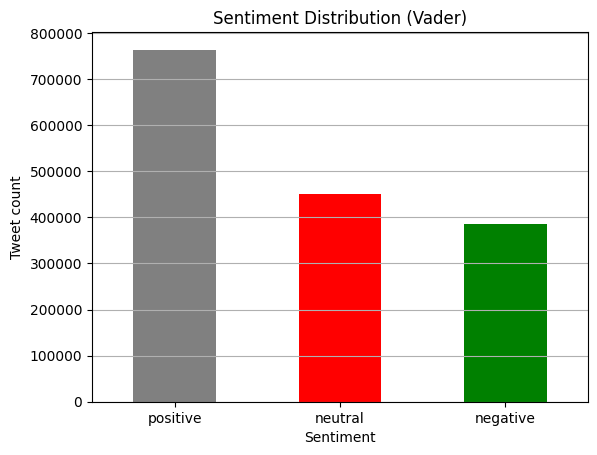

In [10]:
df["vader_sentiment"].value_counts().plot(kind = 'bar', color= ["gray", "red", "green"])
plt.title("Sentiment Distribution (Vader)")
plt.xlabel("Sentiment")
plt.ylabel("Tweet count")
plt.xticks(rotation = 0)
plt.grid(axis = 'y')
plt.show()

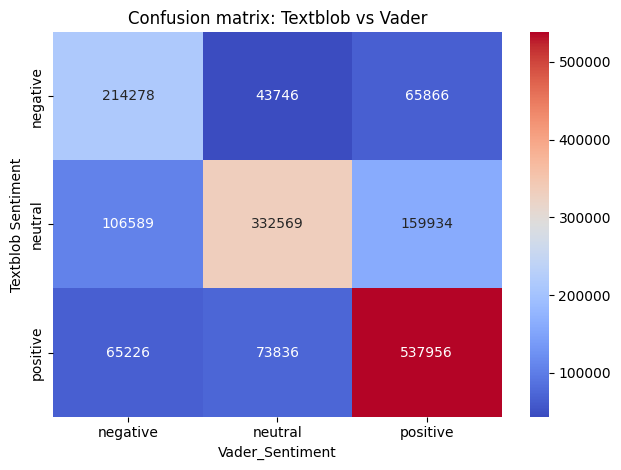

In [11]:
cm = pd.crosstab(df["textblob_sentiment"], df["vader_sentiment"])
sb.heatmap(cm, annot = True, fmt = 'd', cmap = 'coolwarm')
plt.title("Confusion matrix: Textblob vs Vader")
plt.xlabel("Vader_Sentiment")
plt.ylabel("Textblob Sentiment")
plt.tight_layout()
plt.show()

In [12]:
labels = ["positive", "negative"]
print("TextBlob:")
print(classification_report(df["sentiment"], df["textblob_sentiment"],labels=labels, zero_division=0))

print("VADER:")
print(classification_report(df["sentiment"], df["vader_sentiment"], labels=labels, zero_division=0))

TextBlob:
              precision    recall  f1-score   support

    positive       0.64      0.54      0.59    800000
    negative       0.75      0.30      0.43    800000

   micro avg       0.67      0.42      0.52   1600000
   macro avg       0.69      0.42      0.51   1600000
weighted avg       0.69      0.42      0.51   1600000

VADER:
              precision    recall  f1-score   support

    positive       0.65      0.62      0.63    800000
    negative       0.79      0.38      0.52    800000

   micro avg       0.70      0.50      0.58   1600000
   macro avg       0.72      0.50      0.57   1600000
weighted avg       0.72      0.50      0.57   1600000



## **VADER outperforms TextBlob across all metrics: precision, recall, and especially F1-score**
## **TextBlob is weaker particularly in recall for the negative class (0.30) – meaning it misses many negative tweets.**
## **VADER performs better at detecting both positive and negative sentiments, especially negative ones (F1 = 0.52 vs. 0.43 in TextBlob).**